In [1]:
#Load in Data
import torch
print(torch.__version__)

from torch_geometric.datasets import MoleculeNet
data = MoleculeNet(root=".", name="ESOL")
data

2.0.1


ESOL(1128)

In [2]:
#Check data info
print("Dataset Type: ", type(data))
print("Dataset Features: ", data.num_features)
print("Dataset Target: ", data.num_classes)
print("Dataset Length: ", data.len)
print("Dataset Sample: ", data[0])
print("Sample Nodes: ", data[0].num_nodes)
print("Sample Edges: ", data[0].num_edges)

Dataset Type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset Features:  9
Dataset Target:  734
Dataset Length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset Sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample Nodes:  32
Sample Edges:  68


In [136]:
data.x

tensor([], size=(0, 9), dtype=torch.int64)

In [3]:
#Load into dataframe
import pandas as pd

df_data = pd.DataFrame()
df_data['node_rep'] = [sample.x for sample in data]
df_data['edge_rep'] = [sample.edge_index.t() for sample in data]
df_data['solubility'] = [sample.y for sample in data]
df_data['num_nodes'] = [sample.num_nodes for sample in data]
df_data['num_edges'] = [sample.num_edges for sample in data]
df_data['smiles'] = [sample.smiles for sample in data]
df_data.head(5)


,node_rep,edge_rep,solubility,num_nodes,num_edges,smiles
0,"[[tensor(8), tensor(0), tensor(2), tensor(5), ...","[[tensor(0), tensor(1)], [tensor(1), tensor(0)...",[[tensor(-0.7700)]],32,68,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,"[[tensor(6), tensor(0), tensor(4), tensor(5), ...","[[tensor(0), tensor(1)], [tensor(1), tensor(0)...",[[tensor(-3.3000)]],15,32,Cc1occc1C(=O)Nc2ccccc2
2,"[[tensor(6), tensor(0), tensor(4), tensor(5), ...","[[tensor(0), tensor(1)], [tensor(1), tensor(0)...",[[tensor(-2.0600)]],11,20,CC(C)=CCCC(C)=CC(=O)
3,"[[tensor(6), tensor(0), tensor(3), tensor(5), ...","[[tensor(0), tensor(1)], [tensor(0), tensor(5)...",[[tensor(-7.8700)]],22,52,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,"[[tensor(6), tensor(0), tensor(3), tensor(5), ...","[[tensor(0), tensor(1)], [tensor(0), tensor(4)...",[[tensor(-1.3300)]],5,10,c1ccsc1


In [4]:
#Augment with RDKit features
import rdkit
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdBase
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors

print(rdBase.rdkitVersion)


2020.03.2


In [5]:
df_dataRDKit = df_data

#Mol object
df_dataRDKit['mol'] = df_dataRDKit['smiles'].apply(lambda x: Chem.MolFromSmiles(x,sanitize=True))
df_dataRDKit['mol_H'] = df_dataRDKit['mol'].apply(lambda x: Chem.AddHs(x))
df_dataRDKit['num_of_atoms'] = df_dataRDKit['mol_H'].apply(lambda x: x.GetNumAtoms())
df_dataRDKit['num_of_heavy_atoms'] = df_dataRDKit['mol_H'].apply(lambda x: x.GetNumHeavyAtoms())

#International Chemistry Identifier Key
df_dataRDKit['InChIKey'] = df_dataRDKit['mol'].apply(lambda x: Chem.MolToInchiKey(x))

#Fingerprints
df_dataRDKit['RDKit_FP'] = df_dataRDKit['mol'].apply(lambda x: Chem.RDKFingerprint(x, maxPath=7,fpSize=512).ToBitString())
df_dataRDKit['Morgan_FP'] = df_dataRDKit['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=512).ToBitString())


#Other features
df_dataRDKit['tpsa'] = df_dataRDKit['mol_H'].apply(lambda x: Descriptors.TPSA(x))
df_dataRDKit['mol_w'] = df_dataRDKit['mol_H'].apply(lambda x: Descriptors.ExactMolWt(x))
df_dataRDKit['num_valence_electrons'] = df_dataRDKit['mol_H'].apply(lambda x: Descriptors.NumValenceElectrons(x))
df_dataRDKit['num_heteroatoms'] = df_dataRDKit['mol_H'].apply(lambda x: Descriptors.NumHeteroatoms(x))


df_dataRDKit.head()

,node_rep,edge_rep,solubility,num_nodes,num_edges,smiles,mol,mol_H,num_of_atoms,num_of_heavy_atoms,InChIKey,RDKit_FP,Morgan_FP,tpsa,mol_w,num_valence_electrons,num_heteroatoms
0,"[[tensor(8), tensor(0), tensor(2), tensor(5), ...","[[tensor(0), tensor(1)], [tensor(1), tensor(0)...",[[tensor(-0.7700)]],32,68,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,"<img data-content=""rdkit/molecule"" src=""data:i...","<img data-content=""rdkit/molecule"" src=""data:i...",59,32,XUCIJNAGGSZNQT-UHFFFAOYSA-N,1111110011111111111111111101101111111111111111...,0100100000000100000000000000000000000000000001...,202.32,457.158411,178,12
1,"[[tensor(6), tensor(0), tensor(4), tensor(5), ...","[[tensor(0), tensor(1)], [tensor(1), tensor(0)...",[[tensor(-3.3000)]],15,32,Cc1occc1C(=O)Nc2ccccc2,"<img data-content=""rdkit/molecule"" src=""data:i...","<img data-content=""rdkit/molecule"" src=""data:i...",26,15,JFSPBVWPKOEZCB-UHFFFAOYSA-N,0111110001101100111011100111111011101110111010...,0000000000000000000000000000000001000000000000...,42.24,201.078979,76,3
2,"[[tensor(6), tensor(0), tensor(4), tensor(5), ...","[[tensor(0), tensor(1)], [tensor(1), tensor(0)...",[[tensor(-2.0600)]],11,20,CC(C)=CCCC(C)=CC(=O),"<img data-content=""rdkit/molecule"" src=""data:i...","<img data-content=""rdkit/molecule"" src=""data:i...",27,11,WTEVQBCEXWBHNA-UHFFFAOYSA-N,0000000010000000000010001000000000000100100010...,0000000000000000000000000000100001000010000000...,17.07,152.120115,62,1
3,"[[tensor(6), tensor(0), tensor(3), tensor(5), ...","[[tensor(0), tensor(1)], [tensor(0), tensor(5)...",[[tensor(-7.8700)]],22,52,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,"<img data-content=""rdkit/molecule"" src=""data:i...","<img data-content=""rdkit/molecule"" src=""data:i...",36,22,GBROPGWFBFCKAG-UHFFFAOYSA-N,0010000000000000000001000100000000000000100000...,0000000000000000000000000000000000000100000000...,0.00,278.109550,102,0
4,"[[tensor(6), tensor(0), tensor(3), tensor(5), ...","[[tensor(0), tensor(1)], [tensor(0), tensor(4)...",[[tensor(-1.3300)]],5,10,c1ccsc1,"<img data-content=""rdkit/molecule"" src=""data:i...","<img data-content=""rdkit/molecule"" src=""data:i...",9,5,YTPLMLYBLZKORZ-UHFFFAOYSA-N,0011000000000000010000000000000000000000000000...,0000000000000010000000000000000000000000000000...,0.00,84.003371,26,1


In [6]:
#Split into Train, Val, Test
df_dataRDKit_shuffled = df_dataRDKit.sample(frac=1, random_state=1).reset_index()

train_frac = 0.7
val_frac = 0.2

df_train = df_dataRDKit_shuffled.loc[:int(len(df_dataRDKit_shuffled)*train_frac)]
df_val = df_dataRDKit_shuffled.loc[int(len(df_dataRDKit_shuffled)*train_frac)+1:int(len(df_dataRDKit_shuffled)*(train_frac+val_frac))]
df_test = df_dataRDKit_shuffled.loc[int(len(df_dataRDKit_shuffled)*(train_frac+val_frac))+1:]

print("Train:",len(df_train),", Validation:",len(df_val),", Test:",len(df_test))
print('Check sum',len(df_train)+len(df_val)+len(df_test),'equals',len(df_dataRDKit_shuffled))

Train: 790 , Validation: 226 , Test: 112
Check sum 1128 equals 1128


In [7]:
#Formatting desired input fingerprints to numpy arrays
import numpy as np

def fingerprintToArray(fingerprint):
    x_fp_features = fingerprint.values
    x_fp_features_l = [list(map(int,list(fp))) for fp in x_fp_features]
#     print('Samples:',len(x_fp_features_l), 'Features:',len(x_fp_features_l[0]) )
    x_fp_features_a = np.asarray(x_fp_features_l) 
    print('Input:',x_fp_features_a.shape)
    return x_fp_features_a

def formatted(df):
    features = df[['num_of_atoms','num_of_heavy_atoms', 'tpsa', 'mol_w', 'num_valence_electrons', 'num_heteroatoms']].values
    RDKit_FP = fingerprintToArray(df['RDKit_FP'])
    Morgan_FP = fingerprintToArray(df['Morgan_FP'])
    solubility = np.asarray([tensor.item() for tensor in df['solubility'].values])
    print('Output:',solubility.shape)
    return features, RDKit_FP, Morgan_FP, solubility

features_train, RDKitFP_train, MorganFP_train, solubility_train = formatted(df_train)
features_val, RDKitFP_val, MorganFP_val, solubility_val = formatted(df_val)
features_test, RDKitFP_test, MorganFP_test, solubility_test = formatted(df_test)


Input: (790, 512)
Input: (790, 512)
Output: (790,)
Input: (226, 512)
Input: (226, 512)
Output: (226,)
Input: (112, 512)
Input: (112, 512)
Output: (112,)


In [ ]:
#The Task: Predict solubility from molecule info

#Try with different representations: 
#RDKit_FP, Morgan_FP, Features, Graph Representation

#Try with different model architectures: 
#Linear Regression, Ridge Regression, Lasso Regression, Multilayer Perceptron, Graph Convolutional Network 


Linear Regression
MSE: 3.1424381540413315 R2: 0.29914563409425543
MSE: 6.857228086577389 R2: -0.5293596904392881
MSE: 1.1922606291467523 R2: 0.734091483658825

 Ridge Regression
MSE: 2.9007537170161486 R2: 0.35304823600950164
MSE: 5.8928914702754644 R2: -0.31428480444072426
MSE: 1.1922648130825084 R2: 0.7340905505204471

 Lasso Regression
MSE: 1.4469216594863155 R2: 0.6772947270671309
MSE: 2.3201422239825815 R2: 0.48254134926753156
MSE: 1.2017075956862509 R2: 0.731984537580902


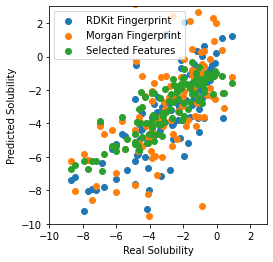

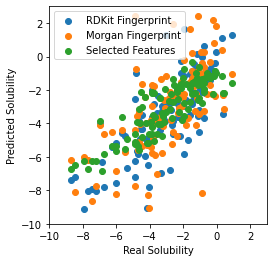

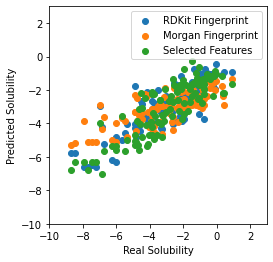

In [31]:
#Linear Regression Models

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def regressionModel(model, x_train, y_train, x_test, y_test): 
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    plt.scatter(y_test,predictions)
    plt.xlim(-10, 3)
    plt.ylim(-10, 3)

    print('MSE:',mean_squared_error(y_test,predictions),'R2:',r2_score(y_test,predictions))

#Linear Regression
print('Linear Regression')
fig,ax = plt.subplots()
plt.xlabel("Real Solubility")
plt.ylabel("Predicted Solubility")
regressionModel(LinearRegression(), RDKitFP_train,solubility_train,RDKitFP_test,solubility_test)
regressionModel(LinearRegression(), MorganFP_train,solubility_train,MorganFP_test,solubility_test)
regressionModel(LinearRegression(), features_train,solubility_train,features_test,solubility_test)
ax.legend(['RDKit Fingerprint', 'Morgan Fingerprint', 'Selected Features'])
ax.set_aspect('equal', adjustable='box')
ax.set_box_aspect(1)

#Ridge Regression - penalize squared magnitudes of coefficients
print('\n Ridge Regression')
fig1,ax1 = plt.subplots()
plt.xlabel("Real Solubility")
plt.ylabel("Predicted Solubility")
regressionModel(Ridge(alpha = 0.05), RDKitFP_train,solubility_train,RDKitFP_test,solubility_test)
regressionModel(Ridge(alpha = 0.05), MorganFP_train,solubility_train,MorganFP_test,solubility_test)
regressionModel(Ridge(alpha = 0.05), features_train,solubility_train,features_test,solubility_test)
ax1.legend(['RDKit Fingerprint', 'Morgan Fingerprint', 'Selected Features'])
ax1.set_aspect('equal', adjustable='box')
ax1.set_box_aspect(1)

#Lasso Regression - penalize abs value magnitudes of coefficients
print('\n Lasso Regression')
fig2,ax2 = plt.subplots()
plt.xlabel("Real Solubility")
plt.ylabel("Predicted Solubility")
regressionModel(Lasso(alpha = 0.05), RDKitFP_train,solubility_train,RDKitFP_test,solubility_test)
regressionModel(Lasso(alpha = 0.05), MorganFP_train,solubility_train,MorganFP_test,solubility_test)
regressionModel(Lasso(alpha = 0.05), features_train,solubility_train,features_test,solubility_test)
ax2.legend(['RDKit Fingerprint', 'Morgan Fingerprint', 'Selected Features'])
ax2.set_aspect('equal', adjustable='box')
ax2.set_box_aspect(1)

In [103]:
#Neural Network - Multi Layer Perceptron ------------------------------------------------------------------
import torch
from torch.nn import Linear
from torch.nn import functional as F


In [104]:
#Prepping data into pytorch DataLoader
from torch_geometric.data import DataLoader

class MyDataset():
    def __init__(self,features, labels):
        self.x = torch.from_numpy(np.asarray(features))
        self.y = torch.from_numpy(np.asarray(labels))
 
    def __len__(self):
        return len(self.y)
   
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]

torch.manual_seed(123456)
RDKit_data_loaded = MyDataset(RDKitFP_train,solubility_train)
RDKit_loader = DataLoader(data_loaded, batch_size = batch_size, shuffle = True)

Morgan_data_loaded = MyDataset(MorganFP_train,solubility_train)
Morgan_loader = DataLoader(Morgan_data_loaded, batch_size = batch_size, shuffle = True)

features_data_loaded = MyDataset(features_train,solubility_train)
features_loader = DataLoader(features_data_loaded, batch_size = batch_size, shuffle = True)


In [109]:
#Define the model - PyTorch

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        torch.manual_seed(123456)
                
        self.dense1 = Linear(512,128)
        self.dense2 = Linear(128,32)
        self.out = Linear(32, 1)
        
        torch.nn.init.xavier_uniform(self.dense1.weight)
        torch.nn.init.xavier_uniform(self.dense2.weight)
        torch.nn.init.xavier_uniform(self.out.weight)
    
    def forward(self, x):
        hidden = self.dense1(x)
        hidden = F.relu(hidden)
        
        hidden = self.dense2(hidden)
        hidden = F.relu(hidden)
        
        out = self.out(hidden)
        return out
    
RDKit_MLP = MLP()
Morgan_MLP = MLP()
features_MLP = MLP()
print(RDKit_MLP)
print("Number of Parameters: ", sum(p.numel() for p in RDKit_MLP.parameters()))
    
#Set GPU usage 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
RDKit_MLP = RDKit_MLP.to(device)   
Morgan_MLP = features_MLP.to(device)   
features_MLP = features_MLP.to(device)  

MLP(
  (dense1): Linear(in_features=512, out_features=128, bias=True)
  (dense2): Linear(in_features=128, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)
Number of Parameters:  69825


In [118]:
#Define the model - PyTorch

class MLP_f(torch.nn.Module):
    def __init__(self):
        super(MLP_f,self).__init__()
        torch.manual_seed(123456)
                
        self.dense1 = Linear(6,512)
        self.dense2 = Linear(512,128)
        self.out = Linear(128, 1)
        
        torch.nn.init.xavier_uniform(self.dense1.weight)
        torch.nn.init.xavier_uniform(self.dense2.weight)
        torch.nn.init.xavier_uniform(self.out.weight)
        
    
    def forward(self, x):
        hidden = self.dense1(x)
        hidden = F.relu(hidden)
        
        hidden = self.dense2(hidden)
        hidden = F.relu(hidden)
        
        out = self.out(hidden)
        return out

features_MLP = MLP_f()

print(features_MLP)
print("Number of Parameters: ", sum(p.numel() for p in features_MLP.parameters()))
    
#Set GPU usage 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
features_MLP = features_MLP.to(device)   

MLP_f(
  (dense1): Linear(in_features=6, out_features=512, bias=True)
  (dense2): Linear(in_features=512, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of Parameters:  69377


Starting Training...
Epoch 0 | Train Loss 1.3581650257110596
Epoch 100 | Train Loss 0.07384604215621948
Epoch 200 | Train Loss 0.09682191908359528
Epoch 300 | Train Loss 0.28746506571769714
Epoch 400 | Train Loss 0.0031306964810937643
Epoch 500 | Train Loss 0.01180122047662735
Epoch 600 | Train Loss 0.1612934023141861
Epoch 700 | Train Loss 0.014946779236197472
Epoch 800 | Train Loss 0.04752140864729881
Epoch 900 | Train Loss 0.03316507115960121


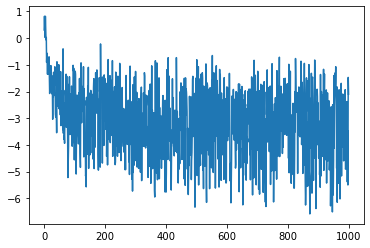

In [111]:
#Training parameters
training_epochs = 1000
batch_size = 64
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(RDKit_MLP.parameters(), lr=0.001)

#Train RDKit
print('Starting Training...')
RDKit_MLP_losses = []
for epoch in range(training_epochs):
    for batch in RDKit_loader:
        batchx = batch[0].to(device)
        batchy = batch[1].to(device)
        optimizer.zero_grad()
        pred = RDKit_MLP(batchx.float())[:,0]
        loss = loss_fn(pred, batchy.float())
        loss.backward()
        optimizer.step()
    RDKit_MLP_losses.append(loss)
    if epoch % 100 == 0: #every 100 epochs print status
        print(f"Epoch {epoch} | Train Loss {loss}")
        
RDKit_losses_indices = [i for i,l in enumerate(RDKit_MLP_losses)]
plt.plot(RDKit_losses_indices,np.log(RDKit_MLP_losses))

Starting Training...
Epoch 0 | Train Loss 4.857322692871094
Epoch 100 | Train Loss 0.014145087450742722
Epoch 200 | Train Loss 0.06097373738884926
Epoch 300 | Train Loss 0.006155825685709715
Epoch 400 | Train Loss 0.008475606329739094
Epoch 500 | Train Loss 0.0025726770982146263
Epoch 600 | Train Loss 0.023992517963051796
Epoch 700 | Train Loss 0.004342054482549429
Epoch 800 | Train Loss 0.0032041866797953844
Epoch 900 | Train Loss 0.0014108478790149093


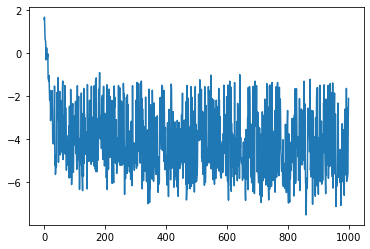

In [112]:
#Training parameters
training_epochs = 1000
batch_size = 64
loss_fn = torch.nn.MSELoss()
m_optimizer = torch.optim.Adam(Morgan_MLP.parameters(), lr=0.001)

#Train Morgan
print('Starting Training...')
Morgan_MLP_losses = []
for epoch in range(training_epochs):
    for batch in Morgan_loader:
        batchx = batch[0].to(device)
        batchy = batch[1].to(device)
        m_optimizer.zero_grad()
        pred = Morgan_MLP(batchx.float())[:,0]
        loss = loss_fn(pred, batchy.float())
        loss.backward()
        m_optimizer.step()
    Morgan_MLP_losses.append(loss)
    if epoch % 100 == 0: #every 100 epochs print status
        print(f"Epoch {epoch} | Train Loss {loss}")
        
Morgan_losses_indices = [i for i,l in enumerate(Morgan_MLP_losses)]
plt.plot(Morgan_losses_indices,np.log(Morgan_MLP_losses))


Starting Training...
Epoch 0 | Train Loss 1.4532610177993774
Epoch 100 | Train Loss 0.8463696837425232
Epoch 200 | Train Loss 0.7218162417411804
Epoch 300 | Train Loss 0.9485329985618591
Epoch 400 | Train Loss 0.9600871205329895
Epoch 500 | Train Loss 0.629111111164093
Epoch 600 | Train Loss 1.001108169555664
Epoch 700 | Train Loss 0.33664676547050476
Epoch 800 | Train Loss 0.493818998336792
Epoch 900 | Train Loss 0.9936416149139404


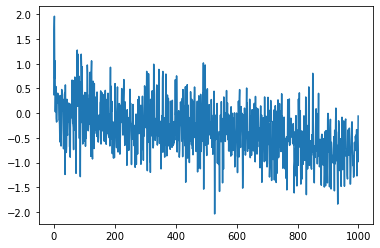

In [119]:
#Training parameters
training_epochs = 1000
batch_size = 64
loss_fn = torch.nn.MSELoss()
f_optimizer = torch.optim.Adam(features_MLP.parameters(), lr=0.001)

#Train features
print('Starting Training...')
features_MLP_losses = []
for epoch in range(training_epochs):
    for batch in features_loader:
        batchx = batch[0].to(device)
        batchy = batch[1].to(device)
        f_optimizer.zero_grad()
        pred = features_MLP(batchx.float())[:,0]
        loss = loss_fn(pred, batchy.float())
        loss.backward()
        f_optimizer.step()
    features_MLP_losses.append(loss)
    if epoch % 100 == 0: #every 100 epochs print status
        print(f"Epoch {epoch} | Train Loss {loss}")
        
features_losses_indices = [i for i,l in enumerate(features_MLP_losses)]
plt.plot(features_losses_indices,np.log(features_MLP_losses))

MSE: 0.8088012538874937 R2: 0.819613986926651
MSE: 1.339006618979205 R2: 0.7013628943877943
MSE: 0.5576227002586007 R2: 0.875634050744392


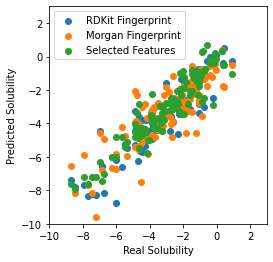

In [242]:
#Predicting data

def visualizePredictions(model, x, y):
    model.to(device)
    with torch.no_grad():
        prediction = model(torch.from_numpy(x).to(device).float())
    prediction = prediction.cpu()
    plt.scatter(y,prediction)
    plt.xlim(-10, 3)
    plt.ylim(-10, 3)
    print('MSE:',mean_squared_error(y,prediction),'R2:',r2_score(y,prediction))

fig,ax = plt.subplots()
plt.xlabel("Real Solubility")
plt.ylabel("Predicted Solubility")
visualizePredictions(RDKit_MLP, RDKitFP_test, solubility_test)
visualizePredictions(Morgan_MLP, MorganFP_test, solubility_test)
visualizePredictions(features_MLP, features_test, solubility_test)
ax.legend(['RDKit Fingerprint','Morgan Fingerprint','Selected Features'])
ax.set_aspect('equal', adjustable='box')
ax.set_box_aspect(1)

In [123]:
#Graph Convolutional Neural Network
#Take in node representation and edge representation
#embed, message pass, pool, then linear output

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

In [236]:
####Define Model

embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        #init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)
        
        #GCN layers
        #Input Layer
        self.initial_conv = GCNConv(data.num_features, embedding_size) #takes in num_features and outputs to embedding size
        
        #Hidden Layers
        self.conv1 = GCNConv(embedding_size, embedding_size)        
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)        
        
        #Output Layer
        self.out = Linear(embedding_size*2, 1) #because using both global average pooling and global max pooling
    
    def forward(self, x, edge_index, batch_index):
        #First Conv Layer
        hidden = self.initial_conv(x, edge_index) #x=atom features, edge_index=bond connectivity
        hidden = F.tanh(hidden) #activation
        
        #Hidden Layers
        hidden = self.conv1(hidden, edge_index) 
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index) 
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index) 
        hidden = F.tanh(hidden) 
        
        #Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), gap(hidden, batch_index)], dim = 1)
        
        #Linear Classifier Output
        out = self.out(hidden)
        
        return out, hidden

graph_model = GCN()
print(graph_model)
print("Number of Parameters: ", sum(p.numel() for p in graph_model.parameters()))
        
#Set GPU usage 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
graph_model = graph_model.to(device)

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of Parameters:  13249


In [237]:
####Define Training

#root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(graph_model.parameters(), lr=0.001)

#Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 32
loader = DataLoader(data[:int(data_size * 0.7)], batch_size=NUM_GRAPHS_PER_BATCH, shuffle = False)
test_loader = DataLoader(data[int(data_size * 0.7):int(data_size * 0.9)], batch_size=NUM_GRAPHS_PER_BATCH, shuffle = False)

def train(data):
    #Enumerate over the data
    for batch in loader:
        #Use GPU
        batch.to(device)
        #Reset gradients
        optimizer.zero_grad()
        #Pass node features and connection info
        pred, embedding = graph_model(batch.x.float(), batch.edge_index, batch.batch)
        #Calculate loss and gradients
        loss = loss_fn(pred, batch.y)
        loss.backward()
        #Update using the gradients
        optimizer.step()
    return loss, embedding


Starting Training...
Epoch 0 | Train Loss 6.449708461761475
Epoch 100 | Train Loss 1.5752767324447632
Epoch 200 | Train Loss 0.9239583611488342
Epoch 300 | Train Loss 0.5815558433532715
Epoch 400 | Train Loss 0.3738369643688202
Epoch 500 | Train Loss 0.26958993077278137
Epoch 600 | Train Loss 0.30123013257980347
Epoch 700 | Train Loss 0.2189815491437912
Epoch 800 | Train Loss 0.14544418454170227
Epoch 900 | Train Loss 0.1866963803768158
Epoch 1000 | Train Loss 0.15725968778133392
Epoch 1100 | Train Loss 0.1394113451242447
Epoch 1200 | Train Loss 0.13512124121189117
Epoch 1300 | Train Loss 0.13267602026462555
Epoch 1400 | Train Loss 0.14534591138362885
Epoch 1500 | Train Loss 0.08566266298294067
Epoch 1600 | Train Loss 0.0935586616396904
Epoch 1700 | Train Loss 0.09596763551235199
Epoch 1800 | Train Loss 0.10263343155384064
Epoch 1900 | Train Loss 0.09409704804420471


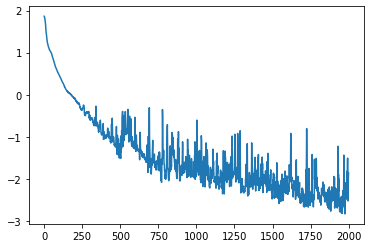

In [238]:
print('Starting Training...')
losses = []
training_epochs = 2000
for epoch in range(training_epochs):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0: #every 100 epochs print status
        print(f"Epoch {epoch} | Train Loss {loss}")

losses_indices = [i for i,l in enumerate(losses)]
plt.plot(losses_indices,np.log(losses))


MSE: 0.8286297034514624 R2: 0.827479477742292


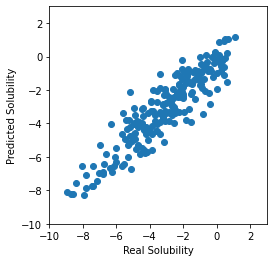

In [241]:
# Predicting data
test_y = []
test_pred = []

with torch.no_grad(): #predicting now, no more training
    for test_batch in test_loader:
        test_batch.to(device)
        pred, embed = graph_model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
        test_y.extend(test_batch.y.tolist())
        test_pred.extend(pred.tolist())

fig,ax = plt.subplots()
plt.xlabel("Real Solubility")
plt.ylabel("Predicted Solubility")        
plt.scatter(test_y, test_pred)
plt.xlim(-10, 3)
plt.ylim(-10, 3)
print('MSE:',mean_squared_error(test_y, test_pred),'R2:',r2_score(test_y, test_pred))
ax.set_aspect('equal', adjustable='box')
ax.set_box_aspect(1)